In [39]:
# IMPORTS
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import copy

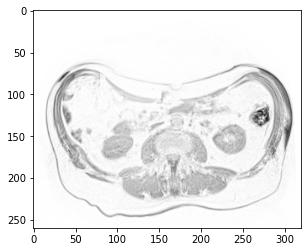

In [10]:
# Show one image
ds = pydicom.read_file("data/IM-0001-0001-0001.dcm")
arr = ds.pixel_array
plt.imshow(arr, cmap='Greys')

(0.0, 10000.0)

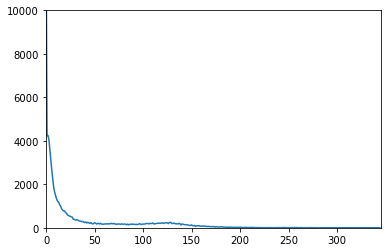

In [27]:
# Plot histogram of the image above
maxValue = np.max(arr)
histogram = np.array([0]*(maxValue+1))
for i in arr:
    for j in i:
        histogram[j] += 1
plt.plot(histogram)
plt.xlim([0, maxValue+1])
plt.ylim([0, 10000])

# We see the histogram does not need any stretching, but needs to be crimped

In [43]:
# Transformation or crimping procedure
Transform = np.arange(0,  maxValue + 1) # This will be the transformation vector
#print(Transform)
#print(np.where(histogram > 0))
deltaA = (maxValue - np.min(np.where(histogram > 0)))/(255)
#print(deltaA)
Transform = np.ceil(Transform / deltaA)
print(Transform)

[  0.   1.   2.   3.   3.   4.   5.   6.   6.   7.   8.   9.   9.  10.
  11.  12.  12.  13.  14.  15.  15.  16.  17.  18.  18.  19.  20.  21.
  21.  22.  23.  23.  24.  25.  26.  26.  27.  28.  29.  29.  30.  31.
  32.  32.  33.  34.  35.  35.  36.  37.  38.  38.  39.  40.  41.  41.
  42.  43.  43.  44.  45.  46.  46.  47.  48.  49.  49.  50.  51.  52.
  52.  53.  54.  55.  55.  56.  57.  58.  58.  59.  60.  61.  61.  62.
  63.  64.  64.  65.  66.  66.  67.  68.  69.  69.  70.  71.  72.  72.
  73.  74.  75.  75.  76.  77.  78.  78.  79.  80.  81.  81.  82.  83.
  84.  84.  85.  86.  86.  87.  88.  89.  89.  90.  91.  92.  92.  93.
  94.  95.  95.  96.  97.  98.  98.  99. 100. 101. 101. 102. 103. 104.
 104. 105. 106. 107. 107. 108. 109. 109. 110. 111. 112. 112. 113. 114.
 115. 115. 116. 117. 118. 118. 119. 120. 121. 121. 122. 123. 124. 124.
 125. 126. 127. 127. 128. 129. 129. 130. 131. 132. 132. 133. 134. 135.
 135. 136. 137. 138. 138. 139. 140. 141. 141. 142. 143. 144. 144. 145.
 146. 

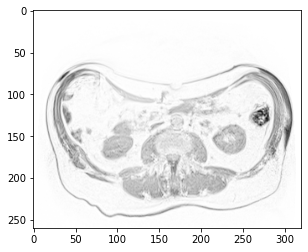

In [45]:
# Apply the transformation to the original image
newArr = copy.deepcopy(arr)
for i in range(len(arr)):
    for j in range(len(arr[i])):
        newArr[i, j] = Transform[arr[i, j]]

# Plot final figure
plt.imshow(newArr, cmap='Greys')



(0.0, 10000.0)

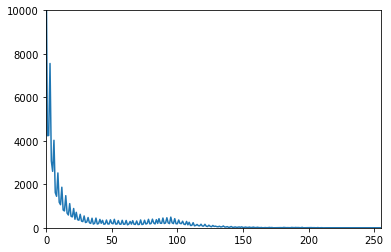

In [48]:
# Plot histogram
histogram = np.array([0]*256)
for i in newArr:
    for j in i:
        histogram[j] += 1
plt.plot(histogram)
plt.xlim([0, 255])
plt.ylim([0, 10000])